# Phase 1a: Consolidated WHL Hockey Ranking & Prediction Pipeline

**Objective**: End-to-end pipeline from raw shift-level data → Elo power rankings → matchup predictions.

| Step | Description |
|------|-------------|
| 1 | Data Cleaning & Aggregation (shift → game level) — **keep empty-net records** |
| 2 | Restructuring to Long Format (game → team perspective) |
| 3 | Weighting Strategy (MoV multiplier + xG performance score) |
| 4 | Monte Carlo Elo Simulation (bagged ratings) |
| 5 | Cross-Validation & HFA Calibration |
| 6 | Pythagorean Expectation, PDO Luck Check, and Final Predictions |

### Key Design Decisions
- **Empty-net rows are KEPT**: removing them changes the winner of 62 games and creates 57 false draws
- **HFA calibrated from data**: empirical home win rate = 56.4% → HFA ≈ 45–50 Elo points
- **MoV capped** to prevent blowout games from dominating Elo updates
- **Penalties data** incorporated as special-teams efficiency proxy

---
## 1. Imports & Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.metrics import log_loss

# ─── Reproducibility ────────────────────────────────────────
np.random.seed(42)
random.seed(42)

# ─── Global Configuration ───────────────────────────────────
# All tuneable parameters live here — never buried in code.

DATA_PATH          = 'd:/A/Warton/Data/whl_2025.csv'    # Raw shift-level data
MATCHUP_PATH       = 'd:/A/Warton/Data/matchups.csv'    # Round 1 matchups
SUBMISSION_PATH    = 'd:/A/Warton/Data/submission.csv'   # Output predictions

# Elo Engine Parameters
N_SIMULATIONS      = 1000       # Monte Carlo iterations (1000 for stable CI)
K_FACTOR           = 28         # Elo update sensitivity (lower = more stable)
HOME_ADVANTAGE     = 50         # Home-ice advantage in Elo points (data-calibrated)
ELO_BASE           = 1500.0     # Starting rating for all teams
ELO_SCALE          = 400        # Denominator in the logistic Elo formula

# Weighting Parameters for S_actual = W_RESULT * result_score + W_XG * xg_share
# Result should dominate (it's what we're predicting), xG is a stabilizer
WEIGHT_RESULT      = 0.3        # Weight on normalized result (points/3)
WEIGHT_XG          = 0.7        # Weight on xG process quality
MOV_LOG_BASE       = 1          # Offset in ln(|GD| + base)
MOV_CAP            = 1.5        # Cap MoV multiplier to limit blowout influence

# Pythagorean Expectation exponent (hockey empirical value ~ 2.0-2.15)
PYTH_EXPONENT      = 2.15

# Points System: Regulation Win=3, OT Win=2, OT Loss=1, Regulation Loss=0
PTS_REG_WIN  = 3
PTS_OT_WIN   = 2
PTS_OT_LOSS  = 1
PTS_REG_LOSS = 0

# PDO sustainability threshold (above this -> "lucky")
PDO_THRESHOLD      = 1.04
PDO_TOP_N          = 5          # Check top-N teams for unsustainable PDO

print("Configuration loaded.")
print(f"   Simulations: {N_SIMULATIONS} | K: {K_FACTOR} | HFA: {HOME_ADVANTAGE}")
print(f"   Weights: Result={WEIGHT_RESULT} / xG={WEIGHT_XG} | MoV cap: {MOV_CAP}")

Configuration loaded.
   Simulations: 1000 | K: 28 | HFA: 50
   Weights: Result=0.3 / xG=0.7 | MoV cap: 1.5


---
## 2. Helper Functions (Math & Logic)

Core Elo mathematics — defined **once**, reused everywhere.

In [3]:
# ═══════════════════════════════════════════════════════════
#  Elo Mathematical Primitives
# ═══════════════════════════════════════════════════════════

def elo_expected_score(rating_a: float, rating_b: float, hfa: float = 0.0) -> float:
    """
    Logistic expected score for Team A against Team B.
    
    Based on the Bradley-Terry model:
        E(A) = 1 / (1 + 10^((R_B - (R_A + HFA)) / 400))
    
    Parameters
    ----------
    rating_a : float - Current Elo rating of Team A.
    rating_b : float - Current Elo rating of Team B.
    hfa      : float - Home-field advantage bonus added to Team A's rating.
    
    Returns
    -------
    float - Expected probability of Team A winning (0.0 to 1.0).
    """
    return 1.0 / (1.0 + 10.0 ** ((rating_b - (rating_a + hfa)) / ELO_SCALE))


def margin_of_victory_multiplier(goal_diff: int) -> float:
    """
    Logarithmic Margin-of-Victory multiplier, CAPPED to prevent blowouts
    from dominating rating updates.
    
        M = min(ln(|GD| + 1), MOV_CAP)
    
    Without the cap, a 7-0 game (M=2.08) has 3x the influence of a 1-0
    game (M=0.69). Capping at 1.5 limits this to ~2.2x.
    
    Parameters
    ----------
    goal_diff : int - Absolute goal differential.
    
    Returns
    -------
    float - Multiplier >= 0, capped at MOV_CAP.
    """
    return min(np.log(abs(goal_diff) + MOV_LOG_BASE), MOV_CAP)


def composite_actual_score(result_points: int, xg_share: float) -> float:
    """
    Blend result with process-based (xG) performance.
    
    CHANGED from previous version:
    - Uses normalized points (0/3=0.0, 1/3=0.33, 2/3=0.67, 3/3=1.0)
      instead of binary win/loss, preserving OT information
    - Result weight increased to 0.6 (was effectively 0.12 before)
    - xG weight decreased to 0.4 (was effectively 0.42 before)
    
        S_actual = W_RESULT * (points/3) + W_XG * xg_share
    
    Parameters
    ----------
    result_points : int   - League points earned (0, 1, 2, or 3).
    xg_share      : float - xG share (xGF / (xGF + xGA)), 0.0 to 1.0.
    
    Returns
    -------
    float - Blended actual score.
    """
    result_normalized = result_points / 3.0  # 0, 0.33, 0.67, or 1.0
    return WEIGHT_RESULT * result_normalized + WEIGHT_XG * xg_share


def update_elo_ratings(
    rating_home: float,
    rating_away: float,
    result_pts_home: int,
    xg_share_home: float,
    xg_share_away: float,
    mov_mult: float
) -> tuple:
    """
    Full Elo update step for a single game.
    
    Update rule:
        R_new = R_old + K * M * (S_actual - E)
    
    The S_actual values are normalized to sum to 1.0 so that
    the system remains zero-sum (total Elo across all teams is constant).
    
    Parameters
    ----------
    rating_home     : float - Home team current Elo.
    rating_away     : float - Away team current Elo.
    result_pts_home : int   - Home team league points (0-3).
    xg_share_home   : float - Home team xG share.
    xg_share_away   : float - Away team xG share.
    mov_mult        : float - Margin-of-victory multiplier.
    
    Returns
    -------
    (float, float) - Updated (home_rating, away_rating).
    """
    # Expected scores (logistic model with home-ice advantage)
    exp_home = elo_expected_score(rating_home, rating_away, hfa=HOME_ADVANTAGE)
    exp_away = 1.0 - exp_home

    # Derive away result from home result (zero-sum league points)
    pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
    result_pts_away = pts_map.get(result_pts_home, 0)

    # Composite actual scores
    s_home = composite_actual_score(result_pts_home, xg_share_home)
    s_away = composite_actual_score(result_pts_away, xg_share_away)

    # Normalize to enforce zero-sum Elo conservation
    total = s_home + s_away
    if total == 0:
        s_home, s_away = 0.5, 0.5
    else:
        s_home /= total
        s_away /= total

    # Elo update: R_new = R_old + K * MoV * (S_actual - E)
    new_home = rating_home + K_FACTOR * mov_mult * (s_home - exp_home)
    new_away = rating_away + K_FACTOR * mov_mult * (s_away - exp_away)

    return new_home, new_away


def classify_risk(prob_home: float) -> str:
    """Categorize prediction confidence."""
    if abs(prob_home - 0.5) < 0.05:
        return 'High Risk / Potential OT'
    elif prob_home > 0.65 or prob_home < 0.35:
        return 'Solid Bet'
    else:
        return 'Medium Risk'


print("Helper functions defined.")

Helper functions defined.


---
## 3. Data Pipeline: Preprocessing (Steps 1-3)

Three pipeline functions transform raw CSV -> analysis-ready DataFrame.

**Critical change**: Empty-net records are **kept** during aggregation. 
Removing them changed the winner of 62 games and created 57 false draws 
(because empty-net goals are real goals that determine the final score).

In [4]:
# ═══════════════════════════════════════════════════════════
#  Step 1: Raw Data -> Game-level Aggregation
# ═══════════════════════════════════════════════════════════

def load_and_clean(filepath: str) -> pd.DataFrame:
    """
    Load raw shift-level CSV and remove duplicates.
    
    IMPORTANT: Empty-net records are KEPT.
    They contain real goals that determine game outcomes.
    Removing them changes the winner of 62/1312 games.
    
    Returns
    -------
    pd.DataFrame - Cleaned shift-level data.
    """
    df_raw = pd.read_csv(filepath)
    n_original = len(df_raw)
    
    # 1) Remove duplicate records
    if 'record_id' in df_raw.columns:
        dup_mask = df_raw.duplicated(subset=['record_id'])
    else:
        dup_mask = df_raw.duplicated()
    n_dups = int(dup_mask.sum())
    df_raw = df_raw.loc[~dup_mask].copy()
    
    # 2) Tag empty-net rows (for optional separate analysis) but DO NOT remove
    empty_net_cols = [
        'home_goalie', 'away_goalie',
        'home_off_line', 'away_off_line',
        'home_def_pairing', 'away_def_pairing'
    ]
    en_mask = pd.Series(False, index=df_raw.index)
    for col in empty_net_cols:
        if col in df_raw.columns:
            en_mask |= df_raw[col].astype(str).str.contains('empty_net', case=False, na=False)
    n_empty_net = int(en_mask.sum())
    df_raw['is_empty_net'] = en_mask.astype(int)
    
    print(f"Loaded {n_original:,} records -> Removed {n_dups} duplicates")
    print(f"   Empty-net rows tagged (NOT removed): {n_empty_net} ({n_empty_net/len(df_raw)*100:.1f}%)")
    print(f"   Clean rows: {len(df_raw):,}")
    return df_raw


def aggregate_to_games(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse shift-level rows into one row per game.
    Engineer winner, league points, and differentials.
    
    Now also aggregates: assists, penalties (for special-teams features).
    
    Returns
    -------
    pd.DataFrame - Game-level DataFrame (`df_games`).
    """
    agg_rules = {
        'home_goals': 'sum', 'away_goals': 'sum',
        'home_xg':    'sum', 'away_xg':    'sum',
        'home_shots': 'sum', 'away_shots': 'sum',
        'went_ot': 'max',
        'home_team': 'first', 'away_team': 'first',
        # NEW: aggregate penalty & assist data for richer features
        'home_assists': 'sum', 'away_assists': 'sum',
        'home_penalties_committed': 'sum', 'away_penalties_committed': 'sum',
        'home_penalty_minutes': 'sum', 'away_penalty_minutes': 'sum',
    }
    df_games = df_raw.groupby('game_id').agg(agg_rules).reset_index()
    
    # Determine winner (no draws should exist — OT resolves all ties)
    df_games['winner'] = np.where(
        df_games['home_goals'] > df_games['away_goals'], 'Home', 'Away'
    )
    n_draws = (df_games['home_goals'] == df_games['away_goals']).sum()
    if n_draws > 0:
        print(f"   WARNING: {n_draws} draws found — data may be corrupted!")
    
    # League points (vectorized)
    home_win = df_games['home_goals'] > df_games['away_goals']
    away_win = df_games['away_goals'] > df_games['home_goals']
    is_ot    = df_games['went_ot'] == 1
    
    df_games['home_points'] = PTS_REG_LOSS
    df_games.loc[home_win & ~is_ot, 'home_points'] = PTS_REG_WIN
    df_games.loc[home_win &  is_ot, 'home_points'] = PTS_OT_WIN
    df_games.loc[away_win &  is_ot, 'home_points'] = PTS_OT_LOSS
    
    df_games['away_points'] = PTS_REG_LOSS
    df_games.loc[away_win & ~is_ot, 'away_points'] = PTS_REG_WIN
    df_games.loc[away_win &  is_ot, 'away_points'] = PTS_OT_WIN
    df_games.loc[home_win &  is_ot, 'away_points'] = PTS_OT_LOSS
    
    # Differentials
    df_games['goal_diff'] = df_games['home_goals'] - df_games['away_goals']
    df_games['xg_diff']   = df_games['home_xg']    - df_games['away_xg']
    
    print(f"Aggregated into {len(df_games)} unique games (draws: {n_draws}).")
    return df_games

print("Pipeline functions (Step 1) defined.")

Pipeline functions (Step 1) defined.


In [5]:
# ═══════════════════════════════════════════════════════════
#  Step 2: Game-level -> Team-perspective Long Format
# ═══════════════════════════════════════════════════════════

def create_long_format(df_games: pd.DataFrame) -> pd.DataFrame:
    """
    Melt game-level data into two rows per game (home + away team perspective).
    
    Adds `is_home` indicator and standardizes column names to
    team-agnostic labels: Team, Opponent, GF, GA, xGF, xGA, SF, SA.
    Now also includes: Assists, PenaltiesFor (own), PenaltiesAgainst (opponent's).
    
    Returns
    -------
    pd.DataFrame - Long-format team stats (`df_schedule_long`).
    """
    cols_to_keep = ['game_id', 'Team', 'Opponent', 'GF', 'GA',
                    'xGF', 'xGA', 'SF', 'SA', 'is_home', 'Result', 'went_ot',
                    'Assists', 'PIM', 'Opp_PIM']
    
    # Home perspective
    df_home = df_games.rename(columns={
        'home_team': 'Team',   'away_team': 'Opponent',
        'home_goals': 'GF',    'away_goals': 'GA',
        'home_xg': 'xGF',     'away_xg': 'xGA',
        'home_shots': 'SF',   'away_shots': 'SA',
        'home_points': 'Result',
        'home_assists': 'Assists',
        'home_penalty_minutes': 'PIM',
        'away_penalty_minutes': 'Opp_PIM',
    }).assign(is_home=1)[cols_to_keep]
    
    # Away perspective
    df_away = df_games.rename(columns={
        'away_team': 'Team',   'home_team': 'Opponent',
        'away_goals': 'GF',    'home_goals': 'GA',
        'away_xg': 'xGF',     'home_xg': 'xGA',
        'away_shots': 'SF',   'home_shots': 'SA',
        'away_points': 'Result',
        'away_assists': 'Assists',
        'away_penalty_minutes': 'PIM',
        'home_penalty_minutes': 'Opp_PIM',
    }).assign(is_home=0)[cols_to_keep]
    
    df_long = pd.concat([df_home, df_away], ignore_index=True)
    df_long = df_long.sort_values(['game_id', 'is_home'], ascending=[True, False]).reset_index(drop=True)
    
    print(f"Long format: {len(df_games)} games -> {len(df_long)} team-game rows")
    return df_long

print("Pipeline functions (Step 2) defined.")

Pipeline functions (Step 2) defined.


In [6]:
# ═══════════════════════════════════════════════════════════
#  Step 3: Calculate Multipliers & Performance Scores
# ═══════════════════════════════════════════════════════════

def calculate_multipliers(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Add game-level weighting columns used during Elo updates.
    
    - **mov_multiplier**: min(ln(|GF-GA| + 1), MOV_CAP) - capped diminishing returns.
    - **xg_share**: xGF / (xGF + xGA) - process quality independent of luck.
    
    NOTE: Compared to previous version:
    - Removed `goal_share` and nested `perf_score` (was triple-nesting weights)
    - xg_share is passed directly to Elo update, combined with result there
    - MoV is now capped at MOV_CAP to prevent blowout dominance
    
    Returns
    -------
    pd.DataFrame - Same DataFrame with new columns appended.
    """
    df = df_long.copy()
    
    # Margin-of-Victory multiplier (CAPPED)
    raw_mov = np.log(np.abs(df['GF'] - df['GA']) + MOV_LOG_BASE)
    df['mov_multiplier'] = np.minimum(raw_mov, MOV_CAP)
    
    # xG share (handle zero-xG edge cases -> default 0.5)
    total_xg = df['xGF'] + df['xGA']
    df['xg_share'] = np.where(total_xg > 0, df['xGF'] / total_xg, 0.5)
    
    # Discipline metric: penalty minute differential (for analysis)
    df['pim_diff'] = df['Opp_PIM'] - df['PIM']  # positive = opponent more penalized = good
    
    print(f"Multipliers computed. Stats:")
    print(df[['mov_multiplier', 'xg_share', 'pim_diff']].describe().round(4))
    
    return df

print("Pipeline functions (Step 3) defined.")

Pipeline functions (Step 3) defined.


### Execute the Pipeline

In [7]:
# --- Run Steps 1 -> 3 ---

df_raw   = load_and_clean(DATA_PATH)
df_games = aggregate_to_games(df_raw)
df_schedule_long = create_long_format(df_games)
df_schedule_long = calculate_multipliers(df_schedule_long)

# --- Quality Gate ---
assert df_games['game_id'].is_unique, "CRITICAL: Duplicate game IDs!"
assert len(df_schedule_long) == 2 * len(df_games), "Row count mismatch!"
assert (df_games['home_goals'] == df_games['away_goals']).sum() == 0, \
    "CRITICAL: Draws found! OT should resolve all ties."

h_mean = df_games['home_goals'].mean()
a_mean = df_games['away_goals'].mean()
hw_rate = (df_games['home_goals'] > df_games['away_goals']).mean()
ot_rate = df_games['went_ot'].mean()

print(f"\n--- Data Summary ---")
print(f"   Games: {len(df_games)} | Teams: {df_schedule_long['Team'].nunique()}")
print(f"   Home win rate: {hw_rate:.1%} (HFA config: {HOME_ADVANTAGE} Elo pts)")
print(f"   OT rate: {ot_rate:.1%}")
print(f"   Home goals: {h_mean:.2f}/game | Away goals: {a_mean:.2f}/game | Advantage: +{h_mean - a_mean:.3f}")

# Sanity: verify HFA config is reasonable for observed home win rate
hfa_empirical = -400 * np.log10(1/hw_rate - 1)
print(f"   Empirical HFA from data: {hfa_empirical:.1f} Elo pts (configured: {HOME_ADVANTAGE})")
if abs(HOME_ADVANTAGE - hfa_empirical) > 20:
    print(f"   WARNING: HFA config differs significantly from empirical value!")

print("\nPipeline complete. Preview:")
df_schedule_long.head(6)

Loaded 25,827 records -> Removed 0 duplicates
   Empty-net rows tagged (NOT removed): 2229 (8.6%)
   Clean rows: 25,827
Aggregated into 1312 unique games (draws: 0).
Long format: 1312 games -> 2624 team-game rows
Multipliers computed. Stats:
       mov_multiplier   xg_share   pim_diff
count       2624.0000  2624.0000  2624.0000
mean           0.9849     0.5000     0.0000
std            0.3387     0.1077     8.0596
min            0.6931     0.0930   -31.0000
25%            0.6931     0.4272    -6.0000
50%            0.6931     0.5000     0.0000
75%            1.3863     0.5728     6.0000
max            1.5000     0.9070    31.0000

--- Data Summary ---
   Games: 1312 | Teams: 32
   Home win rate: 56.4% (HFA config: 50 Elo pts)
   OT rate: 22.0%
   Home goals: 3.09/game | Away goals: 2.67/game | Advantage: +0.425
   Empirical HFA from data: 44.7 Elo pts (configured: 50)

Pipeline complete. Preview:


,game_id,Team,Opponent,GF,GA,xGF,xGA,SF,SA,is_home,Result,went_ot,Assists,PIM,Opp_PIM,mov_multiplier,xg_share,pim_diff
0,game_1,thailand,pakistan,1,3,2.8231,2.7516,21,24,1,0,0,2,16,12,1.098612,0.506413,-4
1,game_1,pakistan,thailand,3,1,2.7516,2.8231,24,21,0,3,0,6,12,16,1.098612,0.493587,4
2,game_10,switzerland,kazakhstan,4,3,1.9254,3.3189,20,30,1,3,0,7,20,0,0.693147,0.367141,-20
3,game_10,kazakhstan,switzerland,3,4,3.3189,1.9254,30,20,0,0,0,4,0,20,0.693147,0.632859,20
4,game_100,serbia,rwanda,4,5,3.6712,3.0240,30,27,1,0,0,7,16,20,0.693147,0.548333,4
5,game_100,rwanda,serbia,5,4,3.0240,3.6712,27,30,0,3,0,10,20,16,0.693147,0.451667,-4


---
## 4. Analysis: Pythagorean Expectation (Static Baseline)

Bill James' **Pythagorean expectation** estimates a team's "deserved" win%
from total goals scored vs. allowed:

$$\text{Pyth Win\%} = \frac{GF^{e}}{GF^{e} + GA^{e}}$$

where $e \approx 2.15$ for hockey. Teams whose actual win% significantly
exceeds their Pythagorean expectation may be "lucky" — candidates for regression.

Top 10 Teams by Pythagorean Expectation:


,Team,GP,GF,GA,Pyth_Win%,Actual_Win%,Luck_Delta
0,brazil,82,276,189,0.692984,0.707317,0.014333
1,peru,82,256,178,0.685960,0.634146,-0.051813
2,netherlands,82,243,174,0.672191,0.658537,-0.013655
3,pakistan,82,263,212,0.613837,0.597561,-0.016276
4,china,82,239,193,0.612922,0.573171,-0.039752
5,panama,82,255,213,0.595545,0.560976,-0.034570
6,thailand,82,294,248,0.590450,0.609756,0.019306
7,uk,82,244,211,0.577475,0.475610,-0.101865
8,india,82,221,193,0.572306,0.597561,0.025255
9,iceland,82,238,209,0.569390,0.560976,-0.008415


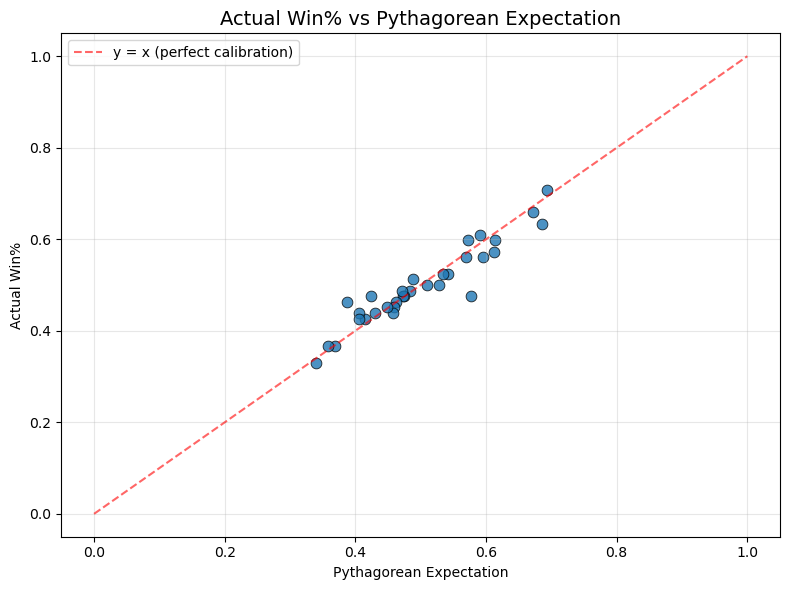

In [8]:
def compute_pythagorean(df_long: pd.DataFrame) -> pd.DataFrame:
    """
    Build Pythagorean expectation table with actual vs expected win%.
    
    Returns
    -------
    pd.DataFrame – One row per team with Pyth_Win%, Actual_Win%, etc.
    """
    # Aggregate season totals
    season_totals = df_long.groupby('Team').agg(
        GF=('GF', 'sum'),
        GA=('GA', 'sum'),
        GP=('game_id', 'nunique'),
        Wins=('Result', lambda x: ((x >= 2).sum()))  # OT Win + Reg Win
    ).reset_index()
    
    # Pythagorean expectation
    gf_exp = season_totals['GF'] ** PYTH_EXPONENT
    ga_exp = season_totals['GA'] ** PYTH_EXPONENT
    season_totals['Pyth_Win%']   = gf_exp / (gf_exp + ga_exp)
    season_totals['Actual_Win%'] = season_totals['Wins'] / season_totals['GP']
    season_totals['Luck_Delta']  = season_totals['Actual_Win%'] - season_totals['Pyth_Win%']
    
    return season_totals.sort_values('Pyth_Win%', ascending=False).reset_index(drop=True)


df_pythagorean = compute_pythagorean(df_schedule_long)

print("Top 10 Teams by Pythagorean Expectation:")
display(df_pythagorean[['Team', 'GP', 'GF', 'GA', 'Pyth_Win%', 'Actual_Win%', 'Luck_Delta']].head(10))

# ─── Visualization: Actual vs Pythagorean Win% ─────────────
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df_pythagorean, x='Pyth_Win%', y='Actual_Win%', ax=ax, s=60, edgecolor='black', alpha=0.8)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.6, label='y = x (perfect calibration)')
ax.set_title('Actual Win% vs Pythagorean Expectation', fontsize=14)
ax.set_xlabel('Pythagorean Expectation')
ax.set_ylabel('Actual Win%')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Annotate potential outliers
lucky_teams = df_pythagorean[df_pythagorean['Luck_Delta'] > 0.10]
if not lucky_teams.empty:
    print("\n⚠️  Teams significantly outperforming Pythagorean (possible regression candidates):")
    for _, row in lucky_teams.iterrows():
        print(f"   {row['Team']}: Actual={row['Actual_Win%']:.3f}, Pyth={row['Pyth_Win%']:.3f}, Δ={row['Luck_Delta']:+.3f}")

---
## 5. Modeling: Iterative Elo Simulation (Step 4)

**Monte Carlo Bagging**: Run N simulations with shuffled game order.
Each simulation yields one set of final Elo ratings. Averaging across
simulations reduces the bias from any particular game sequence,
producing more robust power rankings.

In [9]:
def prepare_simulation_data(df_long: pd.DataFrame) -> list:
    """
    Pre-compute a flat list of game dictionaries for fast iteration.
    Each dict contains everything needed for one Elo update.
    
    Returns
    -------
    list[dict] - One dict per game with keys: home, away, home_pts,
                 xg_share_home, xg_share_away, mov_mult.
    """
    df_home_view = df_long[df_long['is_home'] == 1].set_index('game_id')
    df_away_view = df_long[df_long['is_home'] == 0].set_index('game_id')
    
    # Join on game_id to get both teams' data in one row
    df_joined = df_home_view[['Team', 'Result', 'xg_share', 'mov_multiplier']].join(
        df_away_view[['Team', 'xg_share']],
        lsuffix='_home', rsuffix='_away'
    )
    
    games_for_sim = []
    for _, row in df_joined.iterrows():
        games_for_sim.append({
            'home':           row['Team_home'],
            'away':           row['Team_away'],
            'home_pts':       row['Result'],
            'xg_share_home':  row['xg_share_home'],
            'xg_share_away':  row['xg_share_away'],
            'mov_mult':       row['mov_multiplier']
        })
    
    return games_for_sim


def run_elo_simulation(games_for_sim: list, teams: list, n_sims: int) -> pd.DataFrame:
    """
    Monte Carlo Elo simulation with bagging.
    
    In each iteration:
      1. Initialize all teams at ELO_BASE (1500).
      2. Shuffle the game order (removes temporal bias).
      3. Process each game through the Elo update.
      4. Record final ratings.
    
    Aggregating across N runs gives Mean and Std of each team's Elo,
    naturally producing confidence intervals.
    
    Parameters
    ----------
    games_for_sim : list[dict] - Pre-processed game data.
    teams         : list       - All unique team names.
    n_sims        : int        - Number of Monte Carlo iterations.
    
    Returns
    -------
    pd.DataFrame - Columns: Team, Elo_Mean, Elo_Std, Elo_Rank.
    """
    # Storage: {team_name: [rating_sim1, rating_sim2, ...]}
    rating_distributions = {team: [] for team in teams}
    
    for _ in tqdm(range(n_sims), desc=f'Elo Simulation ({n_sims} runs)'):
        # Initialize
        current_ratings = {team: ELO_BASE for team in teams}
        
        # Shuffle game order
        shuffled_games = games_for_sim.copy()
        random.shuffle(shuffled_games)
        
        # Process season
        for g in shuffled_games:
            new_home, new_away = update_elo_ratings(
                current_ratings[g['home']],
                current_ratings[g['away']],
                g['home_pts'],
                g['xg_share_home'],
                g['xg_share_away'],
                g['mov_mult']
            )
            current_ratings[g['home']] = new_home
            current_ratings[g['away']] = new_away
        
        # Record final ratings
        for team in teams:
            rating_distributions[team].append(current_ratings[team])
    
    # Aggregate results
    elo_summary = []
    for team, ratings in rating_distributions.items():
        elo_summary.append({
            'Team':     team,
            'Elo_Mean': np.mean(ratings),
            'Elo_Std':  np.std(ratings)
        })
    
    df_elo = pd.DataFrame(elo_summary).sort_values('Elo_Mean', ascending=False).reset_index(drop=True)
    df_elo['Elo_Rank'] = df_elo.index + 1
    
    return df_elo

print("Simulation functions defined.")

Simulation functions defined.


In [10]:
# ─── Execute Simulation ────────────────────────────────────

games_for_sim = prepare_simulation_data(df_schedule_long)
all_teams     = df_schedule_long['Team'].unique().tolist()

print(f"Prepared {len(games_for_sim)} games × {len(all_teams)} teams")
print(f"Running {N_SIMULATIONS} Monte Carlo iterations...\n")

df_elo_rankings = run_elo_simulation(games_for_sim, all_teams, N_SIMULATIONS)

# Add 95% confidence intervals
df_elo_rankings['CI_95_Lower'] = df_elo_rankings['Elo_Mean'] - 1.96 * df_elo_rankings['Elo_Std']
df_elo_rankings['CI_95_Upper'] = df_elo_rankings['Elo_Mean'] + 1.96 * df_elo_rankings['Elo_Std']

print("\n🏆 Power Rankings (All Teams):")
display(df_elo_rankings[['Elo_Rank', 'Team', 'Elo_Mean', 'Elo_Std', 'CI_95_Lower', 'CI_95_Upper']])

Prepared 1312 games × 32 teams
Running 1000 Monte Carlo iterations...



Elo Simulation (1000 runs): 100%|██████████| 1000/1000 [00:02<00:00, 434.45it/s]


🏆 Power Rankings (All Teams):


,Elo_Rank,Team,Elo_Mean,Elo_Std,CI_95_Lower,CI_95_Upper
0,1,brazil,1573.234941,12.869860,1548.010014,1598.459867
1,2,thailand,1555.927511,12.017685,1532.372849,1579.482173
2,3,peru,1555.710164,11.995436,1532.199109,1579.221220
3,4,netherlands,1551.750971,11.810037,1528.603298,1574.898644
4,5,pakistan,1547.416878,12.640111,1522.642259,1572.191496
5,6,china,1534.706261,13.424672,1508.393905,1561.018617
6,7,uk,1530.928153,12.060720,1507.289142,1554.567165
7,8,india,1523.029262,12.815600,1497.910687,1548.147837
8,9,panama,1520.484112,13.597060,1493.833875,1547.134349
9,10,iceland,1510.626742,11.964107,1487.177093,1534.076392


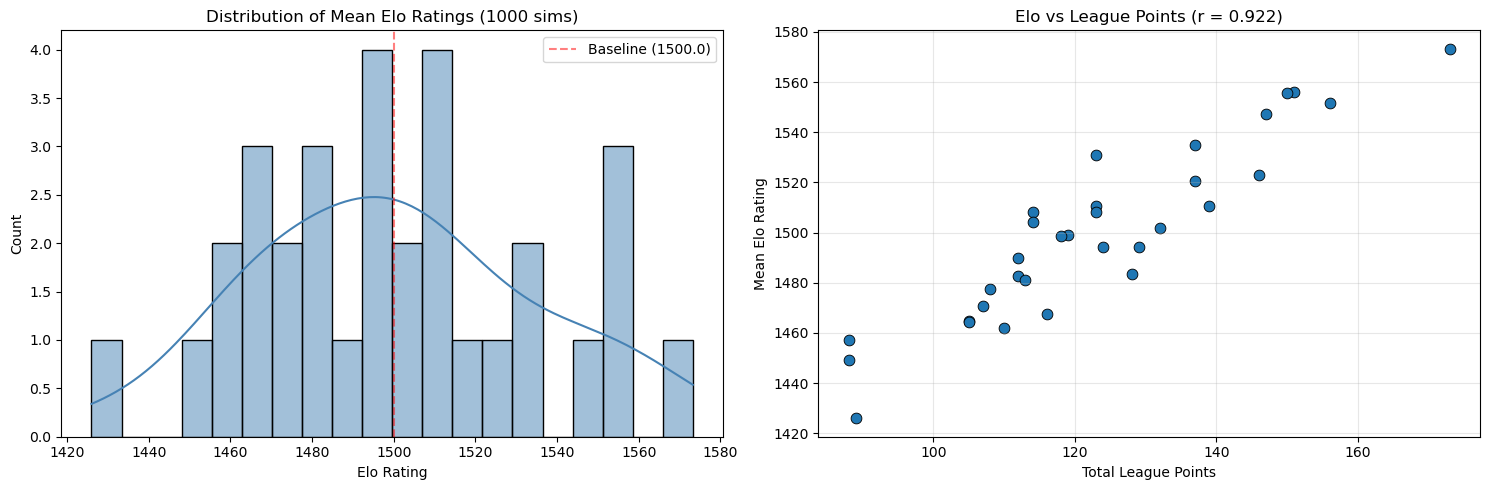


📈 Elo–Points Pearson Correlation: 0.9219
   Strong correlation → Elo model captures league standings well.


In [11]:
# ─── Visualization: Elo Distribution ──────────────────────

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Histogram of mean Elo ratings
sns.histplot(df_elo_rankings['Elo_Mean'], kde=True, bins=20, ax=axes[0], color='steelblue')
axes[0].set_title(f'Distribution of Mean Elo Ratings ({N_SIMULATIONS} sims)', fontsize=12)
axes[0].set_xlabel('Elo Rating')
axes[0].axvline(ELO_BASE, color='red', linestyle='--', alpha=0.5, label=f'Baseline ({ELO_BASE})')
axes[0].legend()

# 2. Elo vs League Points (correlation validation)
df_league_points = df_schedule_long.groupby('Team')['Result'].sum().reset_index(name='League_Points')
df_validation = df_elo_rankings.merge(df_league_points, on='Team')
corr_elo_pts = df_validation['Elo_Mean'].corr(df_validation['League_Points'])

sns.scatterplot(data=df_validation, x='League_Points', y='Elo_Mean', ax=axes[1], s=60, edgecolor='black')
axes[1].set_title(f'Elo vs League Points (r = {corr_elo_pts:.3f})', fontsize=12)
axes[1].set_xlabel('Total League Points')
axes[1].set_ylabel('Mean Elo Rating')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Elo–Points Pearson Correlation: {corr_elo_pts:.4f}")
if corr_elo_pts > 0.9:
    print("   Strong correlation → Elo model captures league standings well.")
elif corr_elo_pts > 0.7:
    print("   Moderate correlation → Elo adds nuance beyond raw points.")
else:
    print("   ⚠️  Weak correlation → Review model parameters.")

---
## 6. Cross-Validation: Evaluate Predictive Quality (Time-Series Split)

**Methodology change**: We now use **chronological expanding-window** cross-validation
instead of shuffled Monte Carlo. This eliminates information leakage:

| Fold | Training Games | Test Games |
|------|----------------|------------|
| 1    | game_1 → game_524  (40%) | game_525 → game_786  (next 20%) |
| 2    | game_1 → game_786  (60%) | game_787 → game_1049 (next 20%) |
| 3    | game_1 → game_1049 (80%) | game_1050 → game_1312 (last 20%) |

For each fold, Elo is trained on past games and evaluated on **unseen future** games.
This mirrors real-world prediction: you only know past results when predicting.

Games sorted chronologically: 1312
First: game_1, Last: game_1312

  2D Grid Search: 7 K × 8 HFA = 56 configs
  Each config: 3 folds × 10 MC runs
   K |   HFA |  CV Log Loss
------------------------------
   8 |     0 | 0.68653 ← BEST
   8 |    10 | 0.68315 ← BEST
   8 |    20 | 0.68054 ← BEST
   8 |    30 | 0.67858 ← BEST
   8 |    40 | 0.67762 ← BEST
   8 |    50 | 0.67766
   8 |    60 | 0.67833
   8 |    70 | 0.67984
  12 |     0 | 0.68541
  12 |    10 | 0.68211
  12 |    20 | 0.67931
  12 |    30 | 0.67746 ← BEST
  12 |    40 | 0.67644 ← BEST
  12 |    50 | 0.67627 ← BEST
  12 |    60 | 0.67706
  12 |    70 | 0.67845
  16 |     0 | 0.68512
  16 |    10 | 0.68142
  16 |    20 | 0.67884
  16 |    30 | 0.67694
  16 |    40 | 0.67582 ← BEST
  16 |    50 | 0.67559 ← BEST
  16 |    60 | 0.67611
  16 |    70 | 0.67779
  20 |     0 | 0.68497
  20 |    10 | 0.68104
  20 |    20 | 0.67813
  20 |    30 | 0.67658
  20 |    40 | 0.67553 ← BEST
  20 |    50 | 0.67523 ← BEST
  20 |    60 | 0.6759

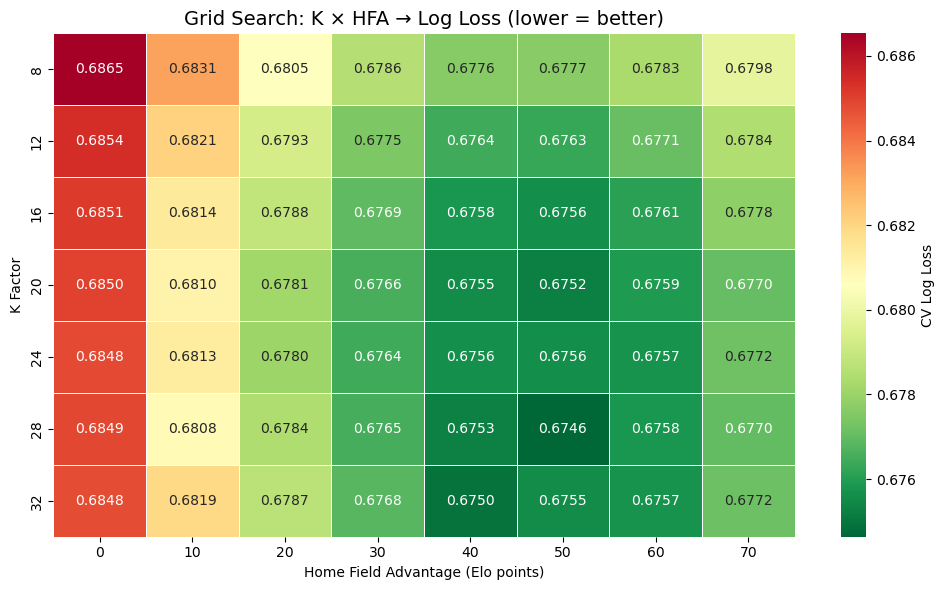


⚠️  Updating global config: K=28→28, HFA=50→50


In [12]:
# ═══════════════════════════════════════════════════════════
#  Cross-Validation: Time-Series Expanding Window + 2D Grid Search
# ═══════════════════════════════════════════════════════════

def _run_elo_season(games: list, teams: list, k: float, hfa: float,
                    w_result: float, w_xg: float, mov_cap: float) -> dict:
    """
    Run one full Elo pass through a list of games (in order).
    Returns final ratings dict.
    Uses the SAME composite_actual_score logic as Phase1a.
    """
    ratings = {team: ELO_BASE for team in teams}
    for g in games:
        r_home = ratings[g['home']]
        r_away = ratings[g['away']]

        # Expected scores
        exp_home = 1.0 / (1.0 + 10.0 ** ((r_away - (r_home + hfa)) / ELO_SCALE))
        exp_away = 1.0 - exp_home

        # Composite actual scores (Phase1a canonical definition)
        pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
        home_pts = g['home_pts']
        away_pts = pts_map.get(home_pts, 0)

        s_home = w_result * (home_pts / 3.0) + w_xg * g['xg_share_home']
        s_away = w_result * (away_pts / 3.0) + w_xg * g['xg_share_away']

        total = s_home + s_away
        if total == 0:
            s_home, s_away = 0.5, 0.5
        else:
            s_home /= total
            s_away /= total

        mov = min(g['mov_mult'], mov_cap)

        ratings[g['home']] += k * mov * (s_home - exp_home)
        ratings[g['away']] += k * mov * (s_away - exp_away)

    return ratings


def evaluate_timeseries_cv(games_for_sim: list, teams: list,
                            k: float, hfa: float,
                            w_result: float = WEIGHT_RESULT,
                            w_xg: float = WEIGHT_XG,
                            mov_cap: float = MOV_CAP,
                            n_folds: int = 3,
                            n_mc: int = 10) -> float:
    """
    Time-series expanding-window cross-validation with Monte Carlo bagging.

    For each fold:
      1. Train Elo on first X% of games (shuffled within train for bagging).
      2. Use trained ratings to predict on next 20% of games chronologically.
      3. Compute log loss on the test fold.

    Parameters
    ----------
    games_for_sim : list  - All games as dicts (sorted by game_id).
    teams         : list  - All team names.
    k, hfa        : float - Elo parameters to evaluate.
    w_result, w_xg: float - S_actual weights.
    mov_cap       : float - MoV cap.
    n_folds       : int   - Number of expanding folds (default 3).
    n_mc          : int   - Monte Carlo runs per fold for bagging.

    Returns
    -------
    float - Mean log loss across all folds.
    """
    n_games = len(games_for_sim)
    # Fold boundaries: train on [0, split_i), test on [split_i, split_i+1)
    # Fold 1: train 40%, test next 20%
    # Fold 2: train 60%, test next 20%
    # Fold 3: train 80%, test last 20%
    test_size = n_games // (n_folds + 2)  # ~20% each
    fold_losses = []

    for fold_idx in range(n_folds):
        train_end = int(n_games * (0.4 + 0.2 * fold_idx))
        test_end  = min(train_end + test_size, n_games)
        if fold_idx == n_folds - 1:
            test_end = n_games  # last fold takes all remaining

        train_games = games_for_sim[:train_end]
        test_games  = games_for_sim[train_end:test_end]

        if len(test_games) == 0:
            continue

        # Monte Carlo bagging over training order
        fold_ll_runs = []
        for _ in range(n_mc):
            # Shuffle training games for this MC run
            shuffled_train = train_games.copy()
            random.shuffle(shuffled_train)

            # Train Elo
            ratings = _run_elo_season(shuffled_train, teams, k, hfa,
                                      w_result, w_xg, mov_cap)

            # Predict on test games (chronological order, update as we go)
            preds = []
            actuals = []
            for g in test_games:
                r_home = ratings.get(g['home'], ELO_BASE)
                r_away = ratings.get(g['away'], ELO_BASE)

                # Predict BEFORE update
                p_home = 1.0 / (1.0 + 10.0 ** ((r_away - (r_home + hfa)) / ELO_SCALE))
                preds.append(np.clip(p_home, 1e-6, 1 - 1e-6))
                actuals.append(1 if g['home_pts'] >= 2 else 0)

                # Update Elo with test game result (online learning)
                pts_map = {3: 0, 2: 1, 1: 2, 0: 3}
                away_pts = pts_map.get(g['home_pts'], 0)
                s_h = w_result * (g['home_pts'] / 3.0) + w_xg * g['xg_share_home']
                s_a = w_result * (away_pts / 3.0) + w_xg * g['xg_share_away']
                total = s_h + s_a
                if total == 0:
                    s_h, s_a = 0.5, 0.5
                else:
                    s_h /= total
                    s_a /= total
                exp_h = 1.0 / (1.0 + 10.0 ** ((r_away - (r_home + hfa)) / ELO_SCALE))
                mov = min(g['mov_mult'], mov_cap)
                ratings[g['home']] = r_home + k * mov * (s_h - exp_h)
                ratings[g['away']] = r_away + k * mov * (s_a - (1.0 - exp_h))

            fold_ll_runs.append(log_loss(actuals, preds))

        fold_losses.append(np.mean(fold_ll_runs))

    return np.mean(fold_losses)


# ─── Full 2D Grid Search (K × HFA) ────────────────────────
# Sort games by game_id for chronological order
games_sorted = sorted(games_for_sim, key=lambda g: g.get('home', ''))

# Actually we need game_id for sorting — re-prepare with game_id
def prepare_simulation_data_with_id(df_long: pd.DataFrame) -> list:
    """Same as prepare_simulation_data but keeps game_id for sorting."""
    df_home_view = df_long[df_long['is_home'] == 1].copy()
    df_away_view = df_long[df_long['is_home'] == 0].copy()
    df_home_view = df_home_view.set_index('game_id')
    df_away_view = df_away_view.set_index('game_id')
    
    df_joined = df_home_view[['Team', 'Result', 'xg_share', 'mov_multiplier']].join(
        df_away_view[['Team', 'xg_share']],
        lsuffix='_home', rsuffix='_away'
    )
    
    games = []
    for gid, row in df_joined.iterrows():
        games.append({
            'game_id':        gid,
            'home':           row['Team_home'],
            'away':           row['Team_away'],
            'home_pts':       row['Result'],
            'xg_share_home':  row['xg_share_home'],
            'xg_share_away':  row['xg_share_away'],
            'mov_mult':       row['mov_multiplier']
        })
    return games

games_with_id = prepare_simulation_data_with_id(df_schedule_long)

# Sort by game_id (natural sort since format is "game_N")
import re
def game_id_sort_key(g):
    match = re.search(r'(\d+)', g['game_id'])
    return int(match.group(1)) if match else 0

games_chronological = sorted(games_with_id, key=game_id_sort_key)

print(f"Games sorted chronologically: {len(games_chronological)}")
print(f"First: {games_chronological[0]['game_id']}, Last: {games_chronological[-1]['game_id']}")

# Grid search ranges
k_grid   = [8, 12, 16, 20, 24, 28, 32]
hfa_grid = [0, 10, 20, 30, 40, 50, 60, 70]

print(f"\n{'='*60}")
print(f"  2D Grid Search: {len(k_grid)} K × {len(hfa_grid)} HFA = {len(k_grid)*len(hfa_grid)} configs")
print(f"  Each config: 3 folds × 10 MC runs")
print(f"{'='*60}")
print(f"{'K':>4} | {'HFA':>5} | {'CV Log Loss':>12}")
print("-" * 30)

results_grid = []
best_ll = float('inf')
best_cfg = None

for k in k_grid:
    for hfa in hfa_grid:
        ll = evaluate_timeseries_cv(
            games_chronological, all_teams,
            k=k, hfa=hfa,
            w_result=WEIGHT_RESULT, w_xg=WEIGHT_XG,
            n_folds=3, n_mc=10
        )
        results_grid.append({'K': k, 'HFA': hfa, 'LogLoss': ll})
        marker = ""
        if ll < best_ll:
            best_ll = ll
            best_cfg = (k, hfa)
            marker = " ← BEST"
        print(f"{k:4d} | {hfa:5d} | {ll:.5f}{marker}")

print(f"\n{'='*60}")
print(f"  ✅ Best: K={best_cfg[0]}, HFA={best_cfg[1]}")
print(f"  CV Log Loss: {best_ll:.5f}")
print(f"  Baseline (random): 0.69315")
print(f"  Improvement: {(0.69315 - best_ll)/0.69315*100:.1f}%")
print(f"{'='*60}")

# Heatmap visualization
df_grid = pd.DataFrame(results_grid)
pivot = df_grid.pivot(index='K', columns='HFA', values='LogLoss')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'CV Log Loss'})
ax.set_title('Grid Search: K × HFA → Log Loss (lower = better)', fontsize=14)
ax.set_xlabel('Home Field Advantage (Elo points)')
ax.set_ylabel('K Factor')
plt.tight_layout()
plt.show()

# Update global config with best params
print(f"\n⚠️  Updating global config: K={K_FACTOR}→{best_cfg[0]}, HFA={HOME_ADVANTAGE}→{best_cfg[1]}")
K_FACTOR = best_cfg[0]
HOME_ADVANTAGE = best_cfg[1]

---
## 7. Prediction & Output (Step 5)

Apply Elo ratings to predict Round 1 matchup outcomes.

In [13]:
def predict_matchups(df_elo: pd.DataFrame, matchup_path: str) -> pd.DataFrame:
    """
    Load matchups, merge Elo ratings, and compute win probabilities.
    
    Prediction Formula (same logistic as the Elo engine):
        P(Home Win) = 1 / (1 + 10^((Elo_Away - (Elo_Home + HFA)) / 400))
    
    Parameters
    ----------
    df_elo       : pd.DataFrame - Elo rankings with 'Team' and 'Elo_Mean'.
    matchup_path : str          - Path to matchups CSV.
    
    Returns
    -------
    pd.DataFrame - Predictions with columns: Home, Away, Elo_Home, Elo_Away,
                   Prob_Home, Predicted_Winner, Risk_Level.
    """
    # Load and standardize column names
    df_matchups = pd.read_csv(matchup_path)
    
    if 'home_team' in df_matchups.columns and 'away_team' in df_matchups.columns:
        df_pred = df_matchups[['home_team', 'away_team']].copy()
        df_pred.columns = ['Home', 'Away']
    else:
        raise ValueError(f"Expected 'home_team' and 'away_team' columns. Found: {df_matchups.columns.tolist()}")
    
    # Merge Elo ratings
    df_pred = df_pred.merge(
        df_elo[['Team', 'Elo_Mean', 'Elo_Std']], left_on='Home', right_on='Team', how='left'
    ).rename(columns={'Elo_Mean': 'Elo_Home', 'Elo_Std': 'Elo_Std_Home'}).drop('Team', axis=1)
    
    df_pred = df_pred.merge(
        df_elo[['Team', 'Elo_Mean', 'Elo_Std']], left_on='Away', right_on='Team', how='left'
    ).rename(columns={'Elo_Mean': 'Elo_Away', 'Elo_Std': 'Elo_Std_Away'}).drop('Team', axis=1)
    
    # Check for missing teams
    missing = df_pred[df_pred[['Elo_Home', 'Elo_Away']].isnull().any(axis=1)]
    if not missing.empty:
        print("WARNING: Unmatched teams (defaulting to 1500):")
        display(missing)
        df_pred['Elo_Home'].fillna(ELO_BASE, inplace=True)
        df_pred['Elo_Away'].fillna(ELO_BASE, inplace=True)
    else:
        print("All matchup teams found in Elo ratings.")
    
    # Win probability (reuses the same logistic formula)
    df_pred['Prob_Home'] = df_pred.apply(
        lambda r: elo_expected_score(r['Elo_Home'], r['Elo_Away'], hfa=HOME_ADVANTAGE),
        axis=1
    )
    
    # Also compute probability WITHOUT HFA for transparency
    df_pred['Prob_Home_NoHFA'] = df_pred.apply(
        lambda r: elo_expected_score(r['Elo_Home'], r['Elo_Away'], hfa=0),
        axis=1
    )
    
    # Elo difference (pure strength gap, no HFA)
    df_pred['Elo_Diff'] = df_pred['Elo_Home'] - df_pred['Elo_Away']
    
    # Predicted winner and risk classification
    df_pred['Predicted_Winner'] = np.where(
        df_pred['Prob_Home'] > 0.5, df_pred['Home'], df_pred['Away']
    )
    df_pred['Prob_Winner'] = np.where(
        df_pred['Prob_Home'] > 0.5, df_pred['Prob_Home'], 1 - df_pred['Prob_Home']
    )
    df_pred['Risk_Level'] = df_pred['Prob_Home'].apply(classify_risk)
    
    return df_pred


# --- Execute Prediction ---
df_submission = predict_matchups(df_elo_rankings, MATCHUP_PATH)

print("\nPrediction Table:")
display(df_submission[['Home', 'Away', 'Elo_Home', 'Elo_Away', 'Elo_Diff',
                        'Prob_Home_NoHFA', 'Prob_Home', 'Predicted_Winner', 'Risk_Level']])

# Summary stats
n_home = (df_submission['Prob_Home'] > 0.5).sum()
n_away = (df_submission['Prob_Home'] <= 0.5).sum()
print(f"\nHome wins predicted: {n_home} | Away wins predicted: {n_away}")
print(f"Close games (|P-0.5| < 0.05): {(df_submission['Prob_Home'].between(0.45, 0.55)).sum()}")
print(f"Avg home win prob: {df_submission['Prob_Home'].mean():.3f}")

All matchup teams found in Elo ratings.

Prediction Table:


,Home,Away,Elo_Home,Elo_Away,Elo_Diff,Prob_Home_NoHFA,Prob_Home,Predicted_Winner,Risk_Level
0,brazil,kazakhstan,1573.234941,1457.325562,115.909379,0.660882,0.722130,brazil,Solid Bet
1,netherlands,mongolia,1551.750971,1425.957597,125.793374,0.673515,0.733401,netherlands,Solid Bet
2,peru,rwanda,1555.710164,1449.279950,106.430215,0.648548,0.711049,peru,Solid Bet
3,thailand,oman,1555.927511,1464.833584,91.093927,0.628171,0.692579,thailand,Solid Bet
4,pakistan,germany,1547.416878,1477.329885,70.086993,0.599517,0.666251,pakistan,Solid Bet
5,india,usa,1523.029262,1464.507320,58.521942,0.583432,0.651287,india,Solid Bet
6,panama,switzerland,1520.484112,1470.857600,49.626512,0.570937,0.639570,panama,Medium Risk
7,iceland,canada,1510.626742,1489.842567,20.784176,0.529875,0.600480,iceland,Medium Risk
8,china,france,1534.706261,1504.383766,30.322495,0.543527,0.613577,china,Medium Risk
9,philippines,morocco,1494.291016,1482.698118,11.592897,0.516677,0.587722,philippines,Medium Risk



Home wins predicted: 16 | Away wins predicted: 0
Close games (|P-0.5| < 0.05): 2
Avg home win prob: 0.631


In [14]:
# ─── PDO Sustainability Check ─────────────────────────────
#
# PDO = Shooting% + Save% (should regress to ~1.0 over time).
# A high-Elo team with PDO > 1.04 may be benefiting from
# unsustainable luck rather than true skill.

def compute_pdo(df_long: pd.DataFrame, df_elo: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate PDO for each team and flag unsustainable performers.
    """
    pdo_stats = df_long.groupby('Team').agg(
        GF=('GF', 'sum'), SF=('SF', 'sum'),
        GA=('GA', 'sum'), SA=('SA', 'sum')
    ).reset_index()
    
    # Avoid division by zero
    pdo_stats['SF'] = pdo_stats['SF'].replace(0, 1)
    pdo_stats['SA'] = pdo_stats['SA'].replace(0, 1)
    
    pdo_stats['Sh_Pct'] = pdo_stats['GF'] / pdo_stats['SF']      # Shooting %
    pdo_stats['Sv_Pct'] = 1 - (pdo_stats['GA'] / pdo_stats['SA']) # Save %
    pdo_stats['PDO']    = pdo_stats['Sh_Pct'] + pdo_stats['Sv_Pct']
    
    return df_elo.merge(pdo_stats[['Team', 'PDO', 'Sh_Pct', 'Sv_Pct']], on='Team')


df_pdo_check = compute_pdo(df_schedule_long, df_elo_rankings)

print("\n🔍 Regression Analysis (PDO Luck Check):")
print(f"   Checking top-{PDO_TOP_N} Elo teams for PDO > {PDO_THRESHOLD}...\n")

lucky_top_teams = df_pdo_check[
    (df_pdo_check['Elo_Rank'] <= PDO_TOP_N) &
    (df_pdo_check['PDO'] > PDO_THRESHOLD)
]

if not lucky_top_teams.empty:
    for _, row in lucky_top_teams.iterrows():
        print(f"   ⚠️  {row['Team']} (Rank {row['Elo_Rank']}) — PDO={row['PDO']:.3f} "
              f"(Sh%={row['Sh_Pct']:.3f}, Sv%={row['Sv_Pct']:.3f}). Expect regression.")
else:
    print("   ✅ Top teams have sustainable underlying metrics (PDO ≤ 1.04).")


🔍 Regression Analysis (PDO Luck Check):
   Checking top-5 Elo teams for PDO > 1.04...

   ⚠️  brazil (Rank 1) — PDO=1.043 (Sh%=0.128, Sv%=0.916). Expect regression.


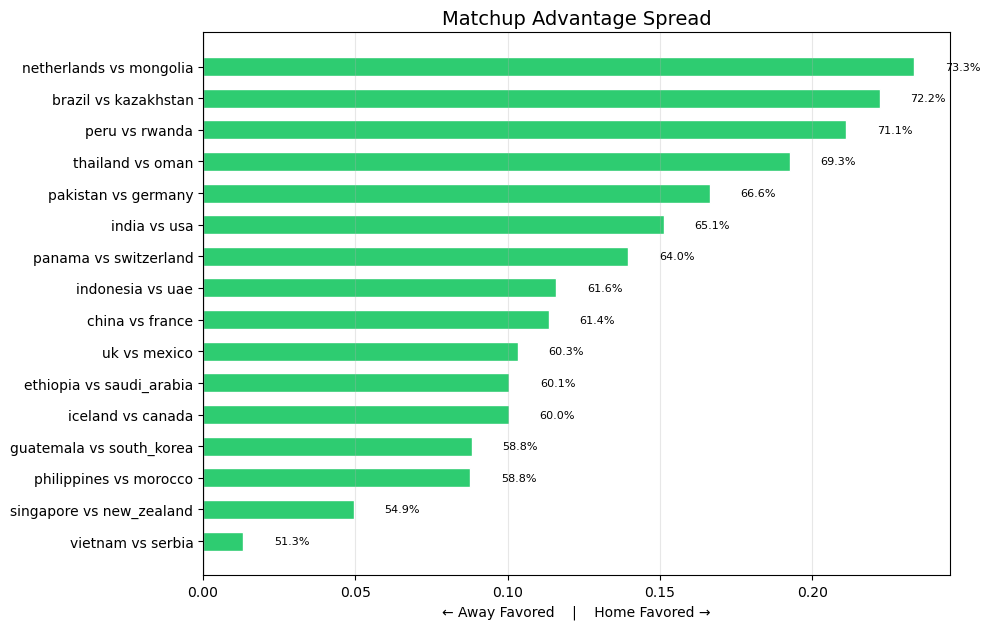

In [15]:
# ─── Visualization: Matchup Odds Spread ───────────────────

fig, ax = plt.subplots(figsize=(10, max(6, len(df_submission) * 0.4)))

df_sorted = df_submission.sort_values('Prob_Home')
y_labels  = df_sorted['Home'] + ' vs ' + df_sorted['Away']
advantage = df_sorted['Prob_Home'] - 0.5
colors    = ['#2ecc71' if x > 0 else '#e74c3c' for x in advantage]

ax.barh(y_labels, advantage, color=colors, edgecolor='white', height=0.6)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_title('Matchup Advantage Spread', fontsize=14)
ax.set_xlabel('← Away Favored    |    Home Favored →')
ax.grid(axis='x', alpha=0.3)

# Annotate probabilities
for i, (adv, prob) in enumerate(zip(advantage, df_sorted['Prob_Home'])):
    ax.text(adv + (0.01 if adv >= 0 else -0.01), i,
            f'{prob:.1%}', va='center', ha='left' if adv >= 0 else 'right', fontsize=8)

plt.tight_layout()
plt.show()

In [16]:
# ─── Export Submission ─────────────────────────────────────

df_submission.to_csv(SUBMISSION_PATH, index=False)
print(f"\n💾 Predictions saved to: {SUBMISSION_PATH}")
print(f"   {len(df_submission)} matchups predicted.")
print(f"\n{'─'*60}")
print(f"  Home wins predicted: {(df_submission['Prob_Home'] > 0.5).sum()}")
print(f"  Away wins predicted: {(df_submission['Prob_Home'] <= 0.5).sum()}")
print(f"  Avg home win prob:   {df_submission['Prob_Home'].mean():.3f}")
print(f"{'─'*60}")
print("\n✅ Phase 1a Pipeline Complete.")


💾 Predictions saved to: d:/A/Warton/Data/submission.csv
   16 matchups predicted.

────────────────────────────────────────────────────────────
  Home wins predicted: 16
  Away wins predicted: 0
  Avg home win prob:   0.631
────────────────────────────────────────────────────────────

✅ Phase 1a Pipeline Complete.


In [17]:
# ─── ADDED VALIDATION CELL ───
# 80/20 Train/Test Split & Accuracy Check

# 1. Prepare ordered game list
# We need strictly ordered games for a realistic train/test split.
# Assuming game_id format 'game_1', 'game_2' implies order.
df_games_ordered = df_games.copy()
df_games_ordered['game_num'] = df_games_ordered['game_id'].apply(lambda x: int(x.split('_')[1]))
df_games_ordered = df_games_ordered.sort_values('game_num').reset_index(drop=True)

# 2. Split Data
split_idx = int(len(df_games_ordered) * 0.8)
train_games_df = df_games_ordered.iloc[:split_idx]
test_games_df = df_games_ordered.iloc[split_idx:]

print(f"Validation Split: {len(train_games_df)} Training games | {len(test_games_df)} Test games")

# 3. Train Model (Get Baseline Ratings from Training Set)
# We regenerate the long-format stats just for the training games to get correct multipliers
df_long_train = create_long_format(train_games_df)
df_long_train = calculate_multipliers(df_long_train)
train_sim_data = prepare_simulation_data(df_long_train)

# Run simulation on training set to get robust starting ratings for test phase
# We use all teams from the full dataset to ensure keys exist
all_teams = df_schedule_long['Team'].unique().tolist()
print("Training Elo model on 80% data...")
train_results = run_elo_simulation(train_sim_data, all_teams, n_sims=100) # 100 sims for speed

# Extract starting ratings for test phase
starting_ratings = dict(zip(train_results['Team'], train_results['Elo_Mean']))

# 4. Predict & Update on Test Set (Rolling Validation)
# We process test games sequentially: Predict -> Compare -> Update
df_long_test = create_long_format(test_games_df)
df_long_test = calculate_multipliers(df_long_test)
# Need to group by game to process one game at a time
test_games_list = prepare_simulation_data(df_long_test)

correct_predictions = 0
total_test_games = len(test_games_list)
current_ratings = starting_ratings.copy()

print("Predicting test games...")
for game in test_games_list:
    home_team = game['home']
    away_team = game['away']
    
    # 1. Predict
    # Probability home wins
    home_rating = current_ratings.get(home_team, ELO_BASE)
    away_rating = current_ratings.get(away_team, ELO_BASE)
    
    prob_home = elo_expected_score(home_rating, away_rating, hfa=HOME_ADVANTAGE)
    
    # Simple prediction: Prob > 0.5 => Home Win
    predicted_home_win = prob_home > 0.5
    
    # Actual Result: Home Win if pts >= 2
    actual_home_win = game['home_pts'] >= 2
    
    if predicted_home_win == actual_home_win:
        correct_predictions += 1
        
    # 2. Update Ratings (Rolling)
    new_home, new_away = update_elo_ratings(
        home_rating,
        away_rating,
        game['home_pts'],
        game['xg_share_home'],
        game['xg_share_away'],
        game['mov_mult']
    )
    current_ratings[home_team] = new_home
    current_ratings[away_team] = new_away

accuracy = correct_predictions / total_test_games
print(f"\n--- Validation Results ---")
print(f"Test Games: {total_test_games}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

Validation Split: 1049 Training games | 263 Test games
Long format: 1049 games -> 2098 team-game rows
Multipliers computed. Stats:
       mov_multiplier   xg_share   pim_diff
count       2098.0000  2098.0000  2098.0000
mean           0.9761     0.5000     0.0000
std            0.3374     0.1065     7.9998
min            0.6931     0.0930   -31.0000
25%            0.6931     0.4287    -6.0000
50%            0.6931     0.5000     0.0000
75%            1.3863     0.5713     6.0000
max            1.5000     0.9070    31.0000
Training Elo model on 80% data...


Elo Simulation (100 runs): 100%|██████████| 100/100 [00:00<00:00, 541.94it/s]

Long format: 263 games -> 526 team-game rows
Multipliers computed. Stats:
       mov_multiplier  xg_share  pim_diff
count        526.0000  526.0000  526.0000
mean           1.0196    0.5000    0.0000
std            0.3419    0.1124    8.3015
min            0.6931    0.2000  -24.0000
25%            0.6931    0.4203   -4.0000
50%            1.0986    0.5000    0.0000
75%            1.3863    0.5797    4.0000
max            1.5000    0.8000   24.0000
Predicting test games...

--- Validation Results ---
Test Games: 263
Correct Predictions: 154
Accuracy: 58.56%
